<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px;width: 180px"><img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo"></td>
        <td style="width: 100%">
            <div style="text-align:right; width: 100%; text-align:right"><font style="font-size:38px"><b>Data Science</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b></b></font></div>
        </td>
    </tr>
</table>

---

# 2.9 Image Classification with Deep Learning

This notebook is a very short introduction to image classification using pre-trained neural networks and `fastai`. The notebook builds on the [tutorial from Jeremy Howard](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data/notebook). You can read the [post by
Hafiz Ahmad Hassan](https://medium.com/@l154359/deep-learning-module-ii-fast-ai-series-image-classification-1-d21be0198aa7) if You are interested in more details.

Using a similar model, Swarowski developed an [binochular](https://www.youtube.com/watch?v=JGjo67vRD4M) that can detect birds in the wild.

![](https://www.austrojagd.at/wp-content/uploads/2024/03/AX-Visio-982262cfb065119b-1-930x568.webp)



## Used Packages

We will use fast.ai. They have the motto of *"Making neural nets uncool again"*. To-do so they developed a framework, which makes it very easy to use state of the art deep-learning models. The concept is similar to `seaborn` which abstracts from `matplotlib` to make nicer looking plots more conveniently.

We start by installing the following Python packages:

In [1]:
# A package to use the duck duck go search engine from within python
!pip install duckduckgo_search

# The fast.ai library
!pip install fastai
!pip install fastcore
!pip install fastbook

# A library to download pictures easily
!pip install fastdownload

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 21.4 MB/s eta 0:00:00


## 2.9.1 Creating the Data-Set

First we need some images to fine-tune our model. Note that we will use a pre-trained model as the training ot the thousands of weights (parameters) would take to much data an time before we would get good results.



### Downloading the Data

We will automatically download the pictures matching a search term from the duckduckgo-search engine:

In [21]:
from fastcore.all import *
from fastbook import search_images_ddg

# create a function that will take an arbitrary search term and return a list of urls.
def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
  return search_images_ddg(term, max_images=max_images)#.itemgot('image')

search_images('grizzly bear')[0]


Searching for 'grizzly bear'


'https://wallpapers.com/images/file/grizzly-bear-pictures-2560-x-2048-o9hsfvsc9zfdzdu9.jpg'

In [22]:
# Testing the function
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you' get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls

Searching for 'bird photos'


(#1) ['https://www.theschoolrun.com/sites/theschoolrun.com/files/istock_birds.jpg']

Next, we download the image in the `images`-subfolder auf our directory:

In [24]:
from fastdownload import download_url
dest = 'data/images/bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('data/images/bird.jpg')

If we want to check the image within the notebook, we can print a thumbnail:

You can imagine that the predicted variable $y$ is the label of the image. The label is the name of the folder, where the image is stored. In particular, the label must be dummy encoded for the model to work.

The predictor $X$ is the image itself, which the color values of each pixel.

In [25]:
from fastai.vision.all import *

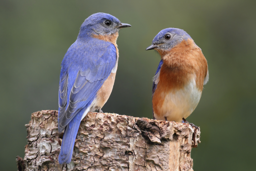

In [26]:
im = Image.open('data/images/bird.jpg')
im.to_thumb(256,256)

The same works for other search terms. In this example, we want to build a classifier that can spot birds.

In [28]:
download_url(search_images('forest photos', max_images=1)[0], 'data/images/forest.jpg', show_progress=False)

Searching for 'forest photos'


Path('data/images/forest.jpg')

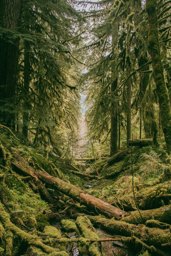

In [29]:
Image.open('data/images/forest.jpg').to_thumb(256,256)

### Downloading Data with different Characteristics and Labels

We want to make sure, that the training data is divers and we do not use the same type of bird over and over again. For this reason, we do not only download the first pictures of birds which could be comics of angry birds instead of ral photos (which are probably bright with sky in the background) and forests (probably dark), but also include different lightning conditions in the search term.

Hence, we adapt our search term `'<bird/forest> photo'` and download multiple pictures with different search terms.

In this case, we have a very easy approach to label the data. We just label everything that has `bird` in the search term as a bird and everything with `forest` as a forest. We also do not need to have a list of the labels, as, we just store all birds in the `bird_or_not/bird` subfolder and vice versa.

In [30]:
# Takes around 3 minutes
# Define the classes
searches = 'forest','bird'

# Define where to store the data
path = Path('data/images/bird_or_not')

# Sleep time so that the search engine does not block us, because of too many requests
from time import sleep

# For all class labels
for class_label in searches:
    # select the folder to store them
    dest = (path/class_label)
    # create the folder if it does not exists
    dest.mkdir(exist_ok=True, parents=True)
    # Use the download function to store the picture
    download_images(dest, urls=search_images(f'{class_label} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{class_label} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{class_label} shade photo'))
    sleep(10)
    resize_images(path/class_label, max_size=400, dest=path/class_label)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Now, we do a quick check to remove corrupted files and remove them.

In [31]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

### Create a Data Block for the Model to train with

Instead of two Dataframes (`X` for the features and `y` for the predicted variable) fast.ai uses a [DataBlock-Objekt](https://docs.fast.ai/data.block.html#datablock), to describe all the data to be loaded for training.


In [32]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),         # Predictor (items) are images, predicted variable are categories
    get_items=get_image_files,                  # The images must be loaded as image
    splitter=RandomSplitter(valid_pct=0.2, seed=42),    # Use 20% of randomly selected pictures for validation
    get_y=parent_label,                         # To get the y-labels use the name of the parent directory
    item_tfms=[Resize(192, method='squish')]    # Transform the data by resizing them to 192x192 pixels and by squishing them
).dataloaders(path, bs=32)                      # Load the date from the path = 'bird_or_not' in a batch size of 32



We can show the data in a table:

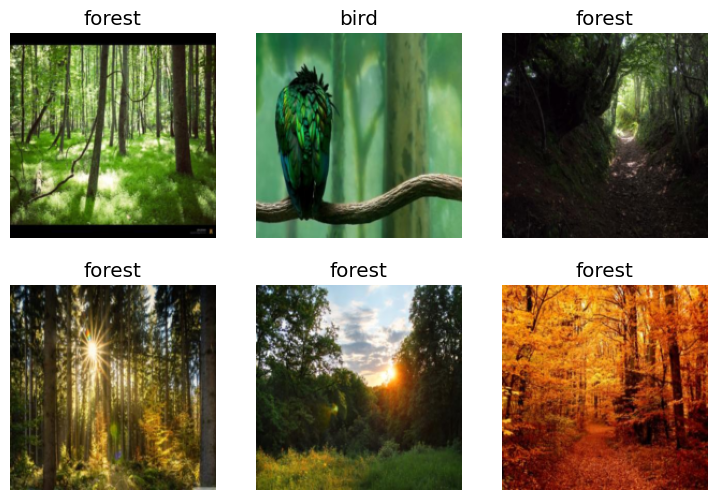

In [33]:
dls.show_batch(max_n=6)                         # Show the first 6 items

Depending in when You downloaded Your pictures You can see, what training data we created. From the squishing some bird might be a litte fat or too lean. However, the ANN will still be able to work with that. We will also have some faulty pictures like pictures of lamps with birds in this example. Hence, in some cases manual sorting might improve the results.

Also note, that we resize the image a lot. This will work fine in this use case, but not in use cases with more focus an detail.

![](https://i.imgur.com/E6ZuClP.png)


## 2.9.2 Training the Model

For training we can select a pre-configured [vision learner](https://docs.fast.ai/vision.learner.html#vision_learner) to which we pass our training-and-validation data `dls`. These models have been trained on thousands of images and are able to classify images with a high accuracy. However, we need to fine-tune the model to our specific use case.

We also select an error metric like the accuracy and a pre-trained network. [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) is a commonly used model that was pre-trained on thousands of pictures and is rather small compared to other models. Hence, it is a good starting point for our use case.

![](https://www.researchgate.net/profile/Muhammed-Enes-Atik-2/publication/349241995/figure/fig2/AS:991139192643586@1613317406497/ResNet-18-architecture-20-The-numbers-added-to-the-end-of-ResNet-represent-the_W640.jpg)

In [34]:
# Select pre-trained model and download it
# Replaces the last layer of the pre-trained model with a new layer that has the right number of outputs for the data classes
learn = vision_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jlhuber/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.6MB/s]


Next we train the model over a given number of runs through the entire training data set (epochs) until a stopping criteria is reached.

In [35]:
# Fine-tune the model
# Usually in two steps: first only the classification layer, then the whole model
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.786425,0.281884,0.806452,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.248342,0.009034,1.000000,00:25
1,0.190550,0.102998,0.967742,00:21
2,0.130579,0.122884,0.967742,00:21


## 2.9.3 Evaluating the Model

We can use the Interpretation of the Model, to get a better understanding how it performed. For instance, we can print a picture form the training with its class and class prediction:

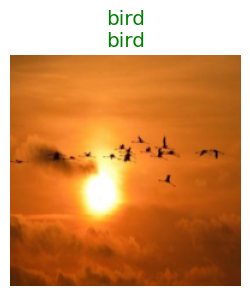

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
@patch
@delegates(TfmdDL.show_results)
def show_at(self:Interpretation, idxs, **kwargs):
    "Show predictions on the items at `idxs`"
    inp, _, targ, dec, _ = self[idxs]
    self.dl.show_results((inp, dec), targ, **kwargs)
interp.show_at(0)

We can also show the model, where the losses during the training were large, which means the model is unvcertain about it's judgement:

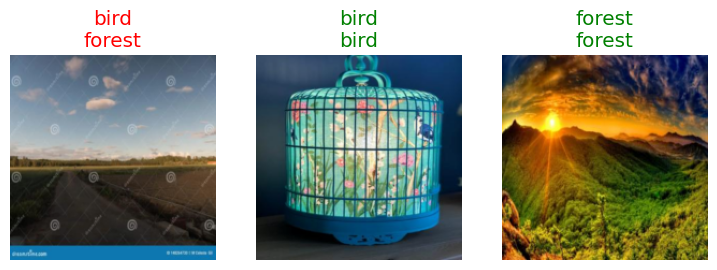

In [38]:
interp.show_at(interp.top_losses(3)[1])

Even, when the model is much more complicated as before, we can still use the same tools, like the confusion Matrix:

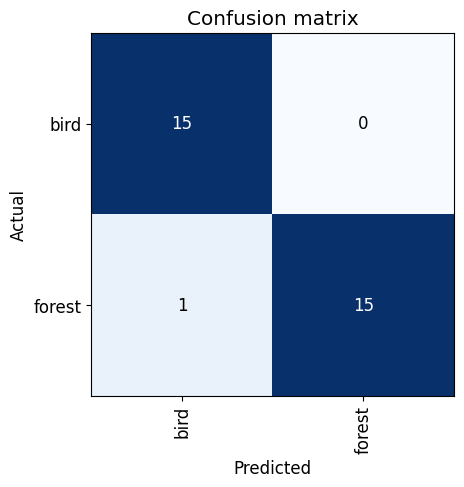

In [39]:
interp.plot_confusion_matrix()

## 2.9.4 Testing the Model

Finally we can test the model with the images we downloaded first. Instead, we could also run it on a test set.

In [40]:
# Make a prediction
Image.open('data/images/bird.jpg').to_thumb(256,256)
predicted_class,_,probs = learn.predict(PILImage.create('data/images/bird.jpg'))
print(f"This is a: {predicted_class}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998


In [41]:
# Make a prediction
Image.open('data/images/forest.jpg').to_thumb(256,256)
predicted_class,_,probs = learn.predict(PILImage.create('data/images/forest.jpg'))
print(f"This is a: {predicted_class}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0001


Searching for 'Donald Trump drinks water'


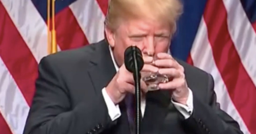

In [48]:
download_url(search_images('Donald Trump drinks water', max_images=1)[0], 'data/images/trump.jpg', show_progress=False)
Image.open('data/images/trump.jpg').to_thumb(256,256)

In [49]:
# Make a prediction
predicted_class,_,probs = learn.predict(PILImage.create('data/images/trump.jpg'))
print(f"This is a: {predicted_class}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a forest: {probs[1]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
Probability it's a forest: 0.0000


✍️ **Task**

- think of another use case for image classification
- copy the notebook and adapt it to Your use case
    - e.g., classify images of different pengiun species

### 🏁 Recap

- 🟥 If you have not finished the tasks, place the red card on top.
- 🟩 If you have finished the tasks and have no questions and want to proceed, place the green card on top.
- 🟨 If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.